# Green Apple: Supply Planning case

Green Apple (GA) products are sold through retailers nationwide. Their operations consist of assembling purchases parts into a multipurpose gardening tool. Because of the limited equipment and space required for its operations, GA’s capacity is mainly determined by the size of its workforce.

Demand for GA’s products is highly seasonal peaking around April. In anticipation of the next season’s demand GA starts planning in the Fall for months of January through June. To meet the peak demand, GA can hire additional workers, subcontract some of the work or build up inventory during the slow months. It could also shift some demand in time by using promotions. Please determine the best use of these options by building an aggregate plan for: regular labor, overtime labor, number of units produced, inventory, subcontracting, and stockouts (backlogged demand).

```
+----------+-----------------+
| Month    | Demand Forecast |
+----------+-----------------+
| January  | 1,600           |
| February | 3,000           |
| March    | 3,200           |
| April    | 3,800           |
| May      | 2,200           |
| June     | 2,200           |
+----------+-----------------+

+-----------------------------+---------------+
| Item                        | Cost          |
+-----------------------------+---------------+
| Materials                   | $10/unit      |
| Inventory holding cost      | $2/unit/month |
| Marginal cost of a stockout | $5/unit/month |
| Hiring and training costs   | $300/worker   |
| Layoff cost                 | $500/worker   |
| Labor hours required        | 4/unit        |
| Regular time cost           | $4/hour       |
| Over time cost              | $6/hour       |
| Cost of subcontracting      | $30/unit      |
+-----------------------------+---------------+
```

* number of workers in the beginning of January: 80
* Initial inventory: 1000
* Minimum inventory at the end of June: 500 (business continuity) and no backlog
* Maximum use of overtime: 10 hours per worker
* Use of subcontracting: unlimited or limited to 500 per month
* Regular unit sales price: \$ 40
* Promotion price: \$ 39, results in an increase of consumption by 10% in the months of the promotion, and shifts 20% of demand from the future two months to the current month.

### Install and import packages

In [ ]:
# Install and import packages
!pip install tabulate
!pip install gurobipy
import numpy as np
from gurobipy import Model, GRB, quicksum
from tabulate import tabulate
import matplotlib.pyplot as plt

ERROR: Operation cancelled by user
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 12.4 MB/s eta 0:00:00


### Raw Data

In [ ]:
### User defined variables
promote = 0
month = 4
base_price = 40
promotion_price = base_price - 1
consumption = 0.10
forward_buy = 0.20

F = np.array([0, 1600, 3000, 3200, 3800, 2200, 2200])

### Variables based on input
n_months = len(F)-1
F = np.append(F, [0, 0])

### Minimize cost using Gurobi integer optimizer

In [ ]:
# Changed it so that now you are required to pass the model outputs
def plot_inventory():
  t_values = list(range(1, n_months + 1))

  plt.plot(t_values, [I[t].x for t in t_values], marker='o', label='Inventory')
  plt.plot(t_values, [P[t].x for t in t_values], marker='s', label='Production')
  plt.plot(t_values, [D[t].x for t in t_values], marker='D', label='Demand')
  plt.plot(t_values, [S[t].x for t in t_values], marker='^', label='Stockout')
  plt.plot(t_values, [C[t].x for t in t_values], marker='x', label='Subcontracting')

  # Adding labels and legend
  plt.xlabel('Period')
  plt.ylabel('')
  plt.legend(loc='best')
  plt.title('Aggregate Plan')
  plt.grid(axis='y')

  # Show the plot
  plt.show()

### Optimization problem

***Minimize Cost***

***subject to:***
  Workforce constraint

  Inventory balance constraint

  Production Capacity constraint

  Overtime constraint
  
  Demand and Stockout constraint

***Decision Variables***

Ht  = Number of employees hired at the beginning of month t, t = 1, ..., 6

Lt  = Number of employees laid off at the beginning of month t, t = 1, ..., 6

Wt  = Workforce size for month t, t = 1, ..., 6

Ot  = Number of overtime hours worked in month t, t = 1, ..., 6

It  = Inventory at the end of month t, t = 1, ..., 6

St  = Number of units stocked out at the end of month t, t = 1, ..., 6

Ct  = Number of units subcontracted for month t, t = 1, ..., 6

Pt  = Production in month t, t = 1, ..., 6

Dt  = Computed Demand in month t, t = 1, ..., 6

+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
| Period | Hired | Laid Off | Workforce | Overtime | Inventory | Stockout | Subcontract | Production | Demand | Price |
|    (t) |   (H) |      (L) |       (W) |      (O) |       (O) |      (S) |         (C) |        (P) |    (D) |  (Pr) |
+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
|      0 |  -0.0 |     -0.0 |      80.0 |     -0.0 |    1000.0 |      0.0 |        -0.0 |       -0.0 |   -0.0 |   nan |
|      1 |   0.0 |     16.0 |      64.0 |     -0.0 |    1960.0 |     -0.0 |        -0.0 |     2560.0 | 1600.0 |  40.0 |
|      2 |   0.0 |     -0.0 |      64.0 |     -0.0 |    1520.0 |     -0.0 |         0.0 |     2560.0 | 3000.0 |  40.0 |
|      3 |   0.0 |     -0.0 |      64.0 |     -0.0 |     880.0 |     -0.0 |         0.0 |     2560.0 | 3200.0 |  40.0 |
|      4 |   0.0 |     -0.0 |      64.0 

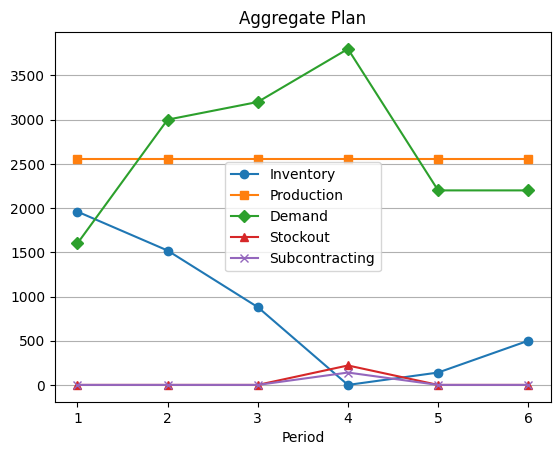

In [ ]:
# Create a Gurobi model
model = Model("MinimizeCost")

H = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(0, n_months+1)}
L = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(0, n_months+1)}
W = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(0, n_months+1)}
O = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(0, n_months+1)}
I = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(0, n_months+1)}
S = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(0, n_months+1)}
C = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(0, n_months+1)}
P = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(0, n_months+1)}
D = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(0, n_months+1)}

# Update the model
model.update()

# Set objective function - Total cost = Production & Transportation cost across network + Fixed cost of low cap line + fixed cost of high cap line
model.setObjective(
    quicksum( 300*H[t] + 500*L[t] + 640*W[t] + 6*O[t] + 2*I[t] + 5*S[t] + 30*C[t] + 10*P[t] for t in range(1, n_months+1) ),
    GRB.MINIMIZE)

### Constraints
for t in range(1, n_months+1):

  # Workforce size for each month is based on hiring and layoffs, W_t = W_{t-1} + H_t - L_t
  model.addConstr(W[0] == 80, name=f"Workforce_Beg")
  model.addConstr(W[t] - W[t-1] - H[t] + L[t] == 0, name=f"Workforce_size_constraint_{t}")

  # Demand constraints
  if promote == 0:
      model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
  else:
      if t == month:
          model.addConstr(D[t] == F[t] * (1 + consumption) + forward_buy * (F[t+1] + F[t+2]), name=f"D_constraint_{t}")
      else:
          if t <= 2 + promote:
              if t > promote:
                  model.addConstr(D[t] == (1 - forward_buy) * F[t], name=f"D_constraint_{t}")
              else:
                  model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
          else:
              model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")

  # Inventory balance constraint: I_{t-1} + P_t + C_t = D_t + S_{t-1} + I_t - S_t
  model.addConstr(I[0] == 1000, name=f"Inventory_Beg")
  model.addConstr(I[t-1] + P[t] + C[t] - D[t] - S[t-1] - I[t] + S[t] == 0, name=f"Inventory_constraint_{t}")
  model.addConstr(I[n_months] >= 500, name=f"Inventory_End")

  # Stockout constraint: No stockout at the end
  model.addConstr(S[n_months] == 0, name=f"Stockout_End")

  # Production <= Capacity P_t <= 40 W_t + O_t/4
  model.addConstr(40*W[t] + O[t]/4 - P[t] >= 0, name=f"Capacity_constraint_{t}")

  # Overtime constraint O_t <= 10 W_t
  model.addConstr(10*W[t] - O[t] >= 0, name=f"Overtime_constraint_{t}")


# Suppress optimization output
model.Params.OutputFlag = 0

# Optimize the model
model.optimize()

### Calculate price
Pr = np.zeros(n_months+1)
for t in range(0, n_months + 1):
  if promote == 1 and t == month:
    Pr[t] = promotion_price
  else:
    Pr[t] = base_price
  if t == 0:
    Pr[t] = np.nan

### Total revenue = sumproduct (demand*price)
revenue = sum([D[t].x * Pr[t] for t in range(1, n_months + 1)])

# Store result in table format and print
opt_results = [[t] + [H[t].x] + [L[t].x] + [W[t].x] + [O[t].x] + [I[t].x] + [S[t].x] + [C[t].x] + [P[t].x] + [D[t].x] + [Pr[t]] for t in range(0, n_months + 1)]

headers = ["Period\n(t)"] + ["Hired\n(H)"] + ["Laid Off\n(L)"] + ["Workforce\n(W)"] + ["Overtime\n(O)"] + ["Inventory\n(O)"] + ["Stockout\n(S)"] + ["Subcontract\n(C)"] + ["Production\n(P)"] + ["Demand\n(D)"] + ["Price\n(Pr)"]
print(tabulate(opt_results, headers=headers, tablefmt="pretty", stralign="right"))

print(f"Minimum Cost : $ {model.objVal:,.2f}")
print(f"Total Revenue: $ {revenue:,.2f}")
print(f"Profit       : $ {(revenue-model.objVal):,.2f}")

plot_inventory()


### 2. What if plants must be built in every market? In this case?

## What-if analysis

1.   Cost of adding/lowering capacity drops from \$300/500 to \$50/50 each
2.   Increase in holding cost (from \$2 to \$6), and then consider subcontracting limited to 500 per month (add constraint)
3.   Over time cost drops to from \$6 to \$4.1 per hour
4.   Increased demand fluctuation (April peak to 4800)

### 1. Cost of adding/lowering capacity drops from \$300/500 to \$50/50 each

+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
| Period | Hired | Laid Off | Workforce | Overtime | Inventory | Stockout | Subcontract | Production | Demand | Price |
|    (t) |   (H) |      (L) |       (W) |      (O) |       (O) |      (S) |         (C) |        (P) |    (D) |  (Pr) |
+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
|      0 |  -0.0 |     -0.0 |      80.0 |     -0.0 |    1000.0 |      0.0 |        -0.0 |       -0.0 |   -0.0 |   nan |
|      1 |   0.0 |     35.0 |      45.0 |     -0.0 |    1200.0 |     -0.0 |        -0.0 |     1800.0 | 1600.0 |  40.0 |
|      2 |   0.0 |     -0.0 |      45.0 |     -0.0 |      -0.0 |     -0.0 |         0.0 |     1800.0 | 3000.0 |  40.0 |
|      3 |  41.0 |     -0.0 |      86.0 |     -0.0 |     240.0 |     -0.0 |         0.0 |     3440.0 | 3200.0 |  40.0 |
|      4 |   1.0 |      0.0 |      87.0 

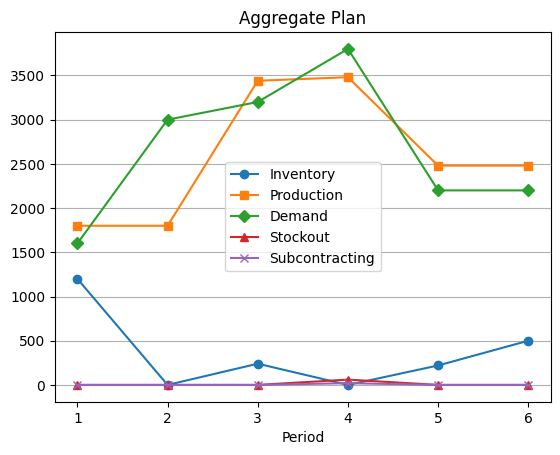

In [ ]:

# Create a Gurobi model
model = Model("MinimizeCost")

H = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(0, n_months+1)}
L = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(0, n_months+1)}
W = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(0, n_months+1)}
O = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(0, n_months+1)}
I = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(0, n_months+1)}
S = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(0, n_months+1)}
C = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(0, n_months+1)}
P = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(0, n_months+1)}
D = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(0, n_months+1)}

# Update the model
model.update()

# Set objective function - Total cost = Production & Transportation cost across network + Fixed cost of low cap line + fixed cost of high cap line
model.setObjective(
    quicksum( 50*H[t] + 50*L[t] + 640*W[t] + 6*O[t] + 2*I[t] + 5*S[t] + 30*C[t] + 10*P[t] for t in range(1, n_months+1) ),
    GRB.MINIMIZE)

### Constraints
for t in range(1, n_months+1):

  # Workforce size for each month is based on hiring and layoffs, W_t = W_{t-1} + H_t - L_t
  model.addConstr(W[0] == 80, name=f"Workforce_Beg")
  model.addConstr(W[t] - W[t-1] - H[t] + L[t] == 0, name=f"Workforce_size_constraint_{t}")

  # Demand constraints
  if promote == 0:
      model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
  else:
      if t == month:
          model.addConstr(D[t] == F[t] * (1 + consumption) + forward_buy * (F[t+1] + F[t+2]), name=f"D_constraint_{t}")
      else:
          if t <= 2 + promote:
              if t > promote:
                  model.addConstr(D[t] == (1 - forward_buy) * F[t], name=f"D_constraint_{t}")
              else:
                  model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
          else:
              model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")

  # Inventory balance constraint: I_{t-1} + P_t + C_t = D_t + S_{t-1} + I_t - S_t
  model.addConstr(I[0] == 1000, name=f"Inventory_Beg")
  model.addConstr(I[t-1] + P[t] + C[t] - D[t] - S[t-1] - I[t] + S[t] == 0, name=f"Inventory_constraint_{t}")
  model.addConstr(I[n_months] >= 500, name=f"Inventory_End")

  # Stockout constraint: No stockout at the end
  model.addConstr(S[n_months] == 0, name=f"Stockout_End")

  # Production <= Capacity P_t <= 40 W_t + O_t/4
  model.addConstr(40*W[t] + O[t]/4 - P[t] >= 0, name=f"Capacity_constraint_{t}")

  # Overtime constraint O_t <= 10 W_t
  model.addConstr(10*W[t] - O[t] >= 0, name=f"Overtime_constraint_{t}")


# Suppress optimization output
model.Params.OutputFlag = 0

# Optimize the model
model.optimize()

### Calculate price
Pr = np.zeros(n_months+1)
for t in range(0, n_months + 1):
  if promote == 1 and t == month:
    Pr[t] = promotion_price
  else:
    Pr[t] = base_price
  if t == 0:
    Pr[t] = np.nan

### Total revenue = sumproduct (demand*price)
revenue = sum([D[t].x * Pr[t] for t in range(1, n_months + 1)])

# Store result in table format and print
opt_results = [[t] + [H[t].x] + [L[t].x] + [W[t].x] + [O[t].x] + [I[t].x] + [S[t].x] + [C[t].x] + [P[t].x] + [D[t].x] + [Pr[t]] for t in range(0, n_months + 1)]

headers = ["Period\n(t)"] + ["Hired\n(H)"] + ["Laid Off\n(L)"] + ["Workforce\n(W)"] + ["Overtime\n(O)"] + ["Inventory\n(O)"] + ["Stockout\n(S)"] + ["Subcontract\n(C)"] + ["Production\n(P)"] + ["Demand\n(D)"] + ["Price\n(Pr)"]
print(tabulate(opt_results, headers=headers, tablefmt="pretty", stralign="right"))

print(f"Minimum Cost : $ {model.objVal:,.2f}")
print(f"Total Revenue: $ {revenue:,.2f}")
print(f"Profit       : $ {(revenue-model.objVal):,.2f}")

plot_inventory()


### 2. Increase in holding cost (from \$2 to \$6), and then consider subcontracting limited to 500 per month (add constraint)

+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
| Period | Hired | Laid Off | Workforce | Overtime | Inventory | Stockout | Subcontract | Production | Demand | Price |
|    (t) |   (H) |      (L) |       (W) |      (O) |       (O) |      (S) |         (C) |        (P) |    (D) |  (Pr) |
+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
|      0 |  -0.0 |     -0.0 |      80.0 |     -0.0 |    1000.0 |      0.0 |        -0.0 |       -0.0 |   -0.0 |   nan |
|      1 |   0.0 |     22.0 |      58.0 |     -0.0 |    1720.0 |     -0.0 |        -0.0 |     2320.0 | 1600.0 |  40.0 |
|      2 |   0.0 |     -0.0 |      58.0 |     -0.0 |    1040.0 |     -0.0 |        -0.0 |     2320.0 | 3000.0 |  40.0 |
|      3 |   0.0 |     -0.0 |      58.0 |     -0.0 |     160.0 |     -0.0 |        -0.0 |     2320.0 | 3200.0 |  40.0 |
|      4 |   9.0 |     -0.0 |      67.0 

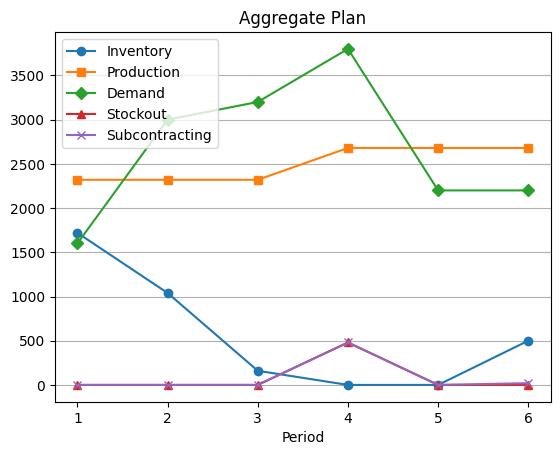

In [ ]:
# Create a Gurobi model
model = Model("MinimizeCost")

H = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(0, n_months+1)}
L = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(0, n_months+1)}
W = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(0, n_months+1)}
O = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(0, n_months+1)}
I = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(0, n_months+1)}
S = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(0, n_months+1)}
C = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(0, n_months+1)}
P = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(0, n_months+1)}
D = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(0, n_months+1)}

# Update the model
model.update()

# Set objective function - Total cost = Production & Transportation cost across network + Fixed cost of low cap line + fixed cost of high cap line
model.setObjective(
    quicksum( 300*H[t] + 500*L[t] + 640*W[t] + 6*O[t] + 6*I[t] + 5*S[t] + 30*C[t] + 10*P[t] for t in range(1, n_months+1) ),
    GRB.MINIMIZE)

### Constraints
for t in range(1, n_months+1):

  # Workforce size for each month is based on hiring and layoffs, W_t = W_{t-1} + H_t - L_t
  model.addConstr(W[0] == 80, name=f"Workforce_Beg")
  model.addConstr(W[t] - W[t-1] - H[t] + L[t] == 0, name=f"Workforce_size_constraint_{t}")

  # Demand constraints
  if promote == 0:
      model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
  else:
      if t == month:
          model.addConstr(D[t] == F[t] * (1 + consumption) + forward_buy * (F[t+1] + F[t+2]), name=f"D_constraint_{t}")
      else:
          if t <= 2 + promote:
              if t > promote:
                  model.addConstr(D[t] == (1 - forward_buy) * F[t], name=f"D_constraint_{t}")
              else:
                  model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
          else:
              model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")

  # Inventory balance constraint: I_{t-1} + P_t + C_t = D_t + S_{t-1} + I_t - S_t
  model.addConstr(I[0] == 1000, name=f"Inventory_Beg")
  model.addConstr(I[t-1] + P[t] + C[t] - D[t] - S[t-1] - I[t] + S[t] == 0, name=f"Inventory_constraint_{t}")
  model.addConstr(I[n_months] >= 500, name=f"Inventory_End")

  # Stockout constraint: No stockout at the end
  model.addConstr(S[n_months] == 0, name=f"Stockout_End")

  # Production <= Capacity P_t <= 40 W_t + O_t/4
  model.addConstr(40*W[t] + O[t]/4 - P[t] >= 0, name=f"Capacity_constraint_{t}")

  # Overtime constraint O_t <= 10 W_t
  model.addConstr(10*W[t] - O[t] >= 0, name=f"Overtime_constraint_{t}")

  # Subcontracting constraint C_t <= 500
  model.addConstr(C[t] <= 500, name=f"Subcontracting_constraint_{t}")


# Suppress optimization output
model.Params.OutputFlag = 0

# Optimize the model
model.optimize()

### Calculate price
Pr = np.zeros(n_months+1)
for t in range(0, n_months + 1):
  if promote == 1 and t == month:
    Pr[t] = promotion_price
  else:
    Pr[t] = base_price
  if t == 0:
    Pr[t] = np.nan

### Total revenue = sumproduct (demand*price)
revenue = sum([D[t].x * Pr[t] for t in range(1, n_months + 1)])

# Store result in table format and print
opt_results = [[t] + [H[t].x] + [L[t].x] + [W[t].x] + [O[t].x] + [I[t].x] + [S[t].x] + [C[t].x] + [P[t].x] + [D[t].x] + [Pr[t]] for t in range(0, n_months + 1)]

headers = ["Period\n(t)"] + ["Hired\n(H)"] + ["Laid Off\n(L)"] + ["Workforce\n(W)"] + ["Overtime\n(O)"] + ["Inventory\n(O)"] + ["Stockout\n(S)"] + ["Subcontract\n(C)"] + ["Production\n(P)"] + ["Demand\n(D)"] + ["Price\n(Pr)"]
print(tabulate(opt_results, headers=headers, tablefmt="pretty", stralign="right"))

print(f"Minimum Cost : $ {model.objVal:,.2f}")
print(f"Total Revenue: $ {revenue:,.2f}")
print(f"Profit       : $ {(revenue-model.objVal):,.2f}")

plot_inventory()


### 3. Over time cost drops to from \$6 to \$4.1 per hour

+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
| Period | Hired | Laid Off | Workforce | Overtime | Inventory | Stockout | Subcontract | Production | Demand | Price |
|    (t) |   (H) |      (L) |       (W) |      (O) |       (O) |      (S) |         (C) |        (P) |    (D) |  (Pr) |
+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
|      0 |  -0.0 |     -0.0 |      80.0 |     -0.0 |    1000.0 |      0.0 |        -0.0 |       -0.0 |   -0.0 |   nan |
|      1 |   0.0 |     16.0 |      64.0 |     -0.0 |    1960.0 |     -0.0 |        -0.0 |     2560.0 | 1600.0 |  40.0 |
|      2 |   0.0 |     -0.0 |      64.0 |     -0.0 |    1520.0 |     -0.0 |         0.0 |     2560.0 | 3000.0 |  40.0 |
|      3 |   0.0 |     -0.0 |      64.0 |     -0.0 |     880.0 |     -0.0 |         0.0 |     2560.0 | 3200.0 |  40.0 |
|      4 |   0.0 |     -0.0 |      64.0 

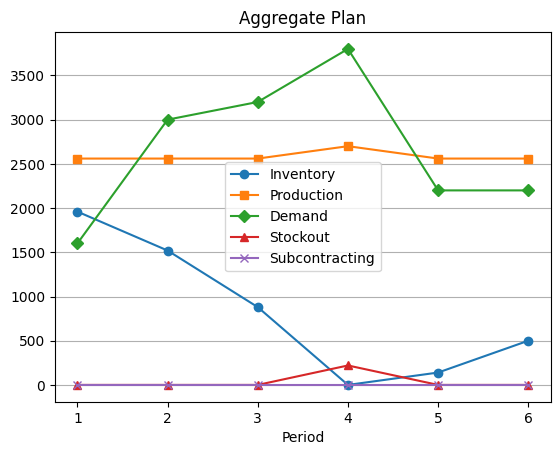

In [ ]:
# Create a Gurobi model
model = Model("MinimizeCost")

H = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(0, n_months+1)}
L = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(0, n_months+1)}
W = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(0, n_months+1)}
O = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(0, n_months+1)}
I = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(0, n_months+1)}
S = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(0, n_months+1)}
C = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(0, n_months+1)}
P = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(0, n_months+1)}
D = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(0, n_months+1)}

# Update the model
model.update()

# Set objective function - Total cost = Production & Transportation cost across network + Fixed cost of low cap line + fixed cost of high cap line
model.setObjective(
    quicksum( 300*H[t] + 500*L[t] + 640*W[t] + 4.1*O[t] + 2*I[t] + 5*S[t] + 30*C[t] + 10*P[t] for t in range(1, n_months+1) ),
    GRB.MINIMIZE)

### Constraints
for t in range(1, n_months+1):

  # Workforce size for each month is based on hiring and layoffs, W_t = W_{t-1} + H_t - L_t
  model.addConstr(W[0] == 80, name=f"Workforce_Beg")
  model.addConstr(W[t] - W[t-1] - H[t] + L[t] == 0, name=f"Workforce_size_constraint_{t}")

  # Demand constraints
  if promote == 0:
      model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
  else:
      if t == month:
          model.addConstr(D[t] == F[t] * (1 + consumption) + forward_buy * (F[t+1] + F[t+2]), name=f"D_constraint_{t}")
      else:
          if t <= 2 + promote:
              if t > promote:
                  model.addConstr(D[t] == (1 - forward_buy) * F[t], name=f"D_constraint_{t}")
              else:
                  model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
          else:
              model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")

  # Inventory balance constraint: I_{t-1} + P_t + C_t = D_t + S_{t-1} + I_t - S_t
  model.addConstr(I[0] == 1000, name=f"Inventory_Beg")
  model.addConstr(I[t-1] + P[t] + C[t] - D[t] - S[t-1] - I[t] + S[t] == 0, name=f"Inventory_constraint_{t}")
  model.addConstr(I[n_months] >= 500, name=f"Inventory_End")

  # Stockout constraint: No stockout at the end
  model.addConstr(S[n_months] == 0, name=f"Stockout_End")

  # Production <= Capacity P_t <= 40 W_t + O_t/4
  model.addConstr(40*W[t] + O[t]/4 - P[t] >= 0, name=f"Capacity_constraint_{t}")

  # Overtime constraint O_t <= 10 W_t
  model.addConstr(10*W[t] - O[t] >= 0, name=f"Overtime_constraint_{t}")


# Suppress optimization output
model.Params.OutputFlag = 0

# Optimize the model
model.optimize()

### Calculate price
Pr = np.zeros(n_months+1)
for t in range(0, n_months + 1):
  if promote == 1 and t == month:
    Pr[t] = promotion_price
  else:
    Pr[t] = base_price
  if t == 0:
    Pr[t] = np.nan

### Total revenue = sumproduct (demand*price)
revenue = sum([D[t].x * Pr[t] for t in range(1, n_months + 1)])

# Store result in table format and print
opt_results = [[t] + [H[t].x] + [L[t].x] + [W[t].x] + [O[t].x] + [I[t].x] + [S[t].x] + [C[t].x] + [P[t].x] + [D[t].x] + [Pr[t]] for t in range(0, n_months + 1)]

headers = ["Period\n(t)"] + ["Hired\n(H)"] + ["Laid Off\n(L)"] + ["Workforce\n(W)"] + ["Overtime\n(O)"] + ["Inventory\n(O)"] + ["Stockout\n(S)"] + ["Subcontract\n(C)"] + ["Production\n(P)"] + ["Demand\n(D)"] + ["Price\n(Pr)"]
print(tabulate(opt_results, headers=headers, tablefmt="pretty", stralign="right"))

print(f"Minimum Cost : $ {model.objVal:,.2f}")
print(f"Total Revenue: $ {revenue:,.2f}")
print(f"Profit       : $ {(revenue-model.objVal):,.2f}")

plot_inventory()


### 4. Increased demand fluctuation (April peak to 4800)

+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
| Period | Hired | Laid Off | Workforce | Overtime | Inventory | Stockout | Subcontract | Production | Demand | Price |
|    (t) |   (H) |      (L) |       (W) |      (O) |       (O) |      (S) |         (C) |        (P) |    (D) |  (Pr) |
+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
|      0 |  -0.0 |     -0.0 |      80.0 |     -0.0 |    1000.0 |      0.0 |        -0.0 |       -0.0 |   -0.0 |   nan |
|      1 |   0.0 |     16.0 |      64.0 |     -0.0 |    1960.0 |     -0.0 |        -0.0 |     2560.0 | 1600.0 |  40.0 |
|      2 |   0.0 |     -0.0 |      64.0 |     -0.0 |    1520.0 |     -0.0 |         0.0 |     2560.0 | 3000.0 |  40.0 |
|      3 |   0.0 |     -0.0 |      64.0 |     -0.0 |     880.0 |     -0.0 |         0.0 |     2560.0 | 3200.0 |  40.0 |
|      4 |   0.0 |     -0.0 |      64.0 

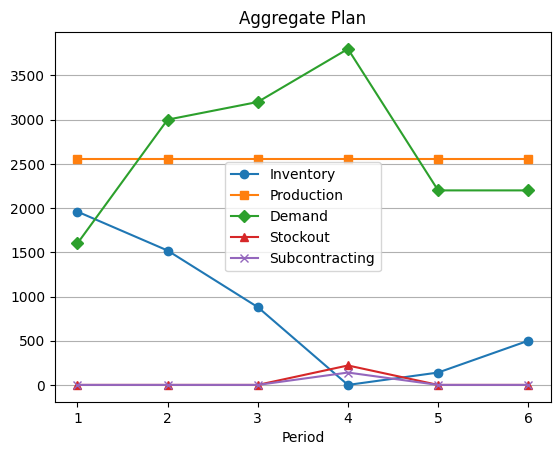

In [ ]:
# Create a Gurobi model
model = Model("MinimizeCost")

F[4] = 4800

H = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(0, n_months+1)}
L = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(0, n_months+1)}
W = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(0, n_months+1)}
O = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(0, n_months+1)}
I = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(0, n_months+1)}
S = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(0, n_months+1)}
C = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(0, n_months+1)}
P = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(0, n_months+1)}
D = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(0, n_months+1)}

# Update the model
model.update()

# Set objective function - Total cost = Production & Transportation cost across network + Fixed cost of low cap line + fixed cost of high cap line
model.setObjective(
    quicksum( 300*H[t] + 500*L[t] + 640*W[t] + 6*O[t] + 2*I[t] + 5*S[t] + 30*C[t] + 10*P[t] for t in range(1, n_months+1) ),
    GRB.MINIMIZE)

### Constraints
for t in range(1, n_months+1):

  # Workforce size for each month is based on hiring and layoffs, W_t = W_{t-1} + H_t - L_t
  model.addConstr(W[0] == 80, name=f"Workforce_Beg")
  model.addConstr(W[t] - W[t-1] - H[t] + L[t] == 0, name=f"Workforce_size_constraint_{t}")

  # Demand constraints
  if promote == 0:
      model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
  else:
      if t == month:
          model.addConstr(D[t] == F[t] * (1 + consumption) + forward_buy * (F[t+1] + F[t+2]), name=f"D_constraint_{t}")
      else:
          if t <= 2 + promote:
              if t > promote:
                  model.addConstr(D[t] == (1 - forward_buy) * F[t], name=f"D_constraint_{t}")
              else:
                  model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
          else:
              model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")

  # Inventory balance constraint: I_{t-1} + P_t + C_t = D_t + S_{t-1} + I_t - S_t
  model.addConstr(I[0] == 1000, name=f"Inventory_Beg")
  model.addConstr(I[t-1] + P[t] + C[t] - D[t] - S[t-1] - I[t] + S[t] == 0, name=f"Inventory_constraint_{t}")
  model.addConstr(I[n_months] >= 500, name=f"Inventory_End")

  # Stockout constraint: No stockout at the end
  model.addConstr(S[n_months] == 0, name=f"Stockout_End")

  # Production <= Capacity P_t <= 40 W_t + O_t/4
  model.addConstr(40*W[t] + O[t]/4 - P[t] >= 0, name=f"Capacity_constraint_{t}")

  # Overtime constraint O_t <= 10 W_t
  model.addConstr(10*W[t] - O[t] >= 0, name=f"Overtime_constraint_{t}")


# Suppress optimization output
model.Params.OutputFlag = 0

# Optimize the model
model.optimize()

### Calculate price
Pr = np.zeros(n_months+1)
for t in range(0, n_months + 1):
  if promote == 1 and t == month:
    Pr[t] = promotion_price
  else:
    Pr[t] = base_price
  if t == 0:
    Pr[t] = np.nan

### Total revenue = sumproduct (demand*price)
revenue = sum([D[t].x * Pr[t] for t in range(1, n_months + 1)])

# Store result in table format and print
opt_results = [[t] + [H[t].x] + [L[t].x] + [W[t].x] + [O[t].x] + [I[t].x] + [S[t].x] + [C[t].x] + [P[t].x] + [D[t].x] + [Pr[t]] for t in range(0, n_months + 1)]

headers = ["Period\n(t)"] + ["Hired\n(H)"] + ["Laid Off\n(L)"] + ["Workforce\n(W)"] + ["Overtime\n(O)"] + ["Inventory\n(O)"] + ["Stockout\n(S)"] + ["Subcontract\n(C)"] + ["Production\n(P)"] + ["Demand\n(D)"] + ["Price\n(Pr)"]
print(tabulate(opt_results, headers=headers, tablefmt="pretty", stralign="right"))

print(f"Minimum Cost : $ {model.objVal:,.2f}")
print(f"Total Revenue: $ {revenue:,.2f}")
print(f"Profit       : $ {(revenue-model.objVal):,.2f}")

plot_inventory()


## Homework Assignment
1. Suppose you are in the month of December, solve the model and record the total cost breakdown by month from January to June.

2. One month has passed and you are in the end of January. It turned out that demand in January was a bit slower 1500 units, instead of 1600.  Also your forecasting team projects that demand in April is going to be 3900. They also added demand in July to be 1100.

3. What impact did the change of demand in January have on costs incurred in January, compared to the planned costs computed in Step 1? Assume that January production went according to the plan developed in December.

4. Obtain the updated sales and operations plan for the months of February through July, while accounting for the realized demand in January (and hence the extra inventory) and updated forecasts for April and July. Compare it with the original plan from Step 1 (show the graph for the updated plan). What is the cost difference between the plans for the months Feb through June?

### (1) Jan-June Base Model

In [ ]:
### User defined variables
promote = 0
month = 4
base_price = 40
promotion_price = base_price - 1
consumption = 0.10
forward_buy = 0.20

F = np.array([0, 1600, 3000, 3200, 3800, 2200, 2200])

### Variables based on input
n_months = len(F)-1
F = np.append(F, [0, 0])
F

array([   0, 1600, 3000, 3200, 3800, 2200, 2200,    0,    0])

In [ ]:
# Create a Gurobi model
model = Model("MinimizeCost")

H = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(0, n_months+1)}
L = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(0, n_months+1)}
W = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(0, n_months+1)}
O = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(0, n_months+1)}
I = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(0, n_months+1)}
S = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(0, n_months+1)}
C = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(0, n_months+1)}
P = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(0, n_months+1)}
D = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(0, n_months+1)}

# Update the model
model.update()

# Set objective function - Total cost = Production & Transportation cost across network + Fixed cost of low cap line + fixed cost of high cap line
model.setObjective(
    quicksum( 300*H[t] + 500*L[t] + 640*W[t] + 6*O[t] + 2*I[t] + 5*S[t] + 30*C[t] + 10*P[t] for t in range(1, n_months+1) ),
    GRB.MINIMIZE)

### Constraints
for t in range(1, n_months+1):

  # Workforce size for each month is based on hiring and layoffs, W_t = W_{t-1} + H_t - L_t
  model.addConstr(W[0] == 80, name=f"Workforce_Beg")
  model.addConstr(W[t] - W[t-1] - H[t] + L[t] == 0, name=f"Workforce_size_constraint_{t}")

  # Demand constraints
  if promote == 0:
      model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
  else:
      if t == month:
          model.addConstr(D[t] == F[t] * (1 + consumption) + forward_buy * (F[t+1] + F[t+2]), name=f"D_constraint_{t}")
      else:
          if t <= 2 + promote:
              if t > promote:
                  model.addConstr(D[t] == (1 - forward_buy) * F[t], name=f"D_constraint_{t}")
              else:
                  model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
          else:
              model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")

  # Inventory balance constraint: I_{t-1} + P_t + C_t = D_t + S_{t-1} + I_t - S_t
  model.addConstr(I[0] == 1000, name=f"Inventory_Beg")
  model.addConstr(I[t-1] + P[t] + C[t] - D[t] - S[t-1] - I[t] + S[t] == 0, name=f"Inventory_constraint_{t}")
  model.addConstr(I[n_months] >= 500, name=f"Inventory_End")

  # Stockout constraint: No stockout at the end
  model.addConstr(S[n_months] == 0, name=f"Stockout_End")

  # Production <= Capacity P_t <= 40 W_t + O_t/4
  model.addConstr(40*W[t] + O[t]/4 - P[t] >= 0, name=f"Capacity_constraint_{t}")

  # Overtime constraint O_t <= 10 W_t
  model.addConstr(10*W[t] - O[t] >= 0, name=f"Overtime_constraint_{t}")


# Suppress optimization output
model.Params.OutputFlag = 0

# Optimize the model
model.optimize()

### Calculate price
Pr = np.zeros(n_months+1)
for t in range(0, n_months + 1):
  if promote == 1 and t == month:
    Pr[t] = promotion_price
  else:
    Pr[t] = base_price
  if t == 0:
    Pr[t] = np.nan

### Total revenue = sumproduct (demand*price)
revenue = sum([D[t].x * Pr[t] for t in range(1, n_months + 1)])

months = ["December", "January", "February", "March", "April", "May", "June"]

# Store result in table format and print
opt_results = [[months[t]] + [H[t].x] + [L[t].x] + [W[t].x] + [O[t].x] + [I[t].x] + [S[t].x] + [C[t].x] + [P[t].x] + [D[t].x] + [Pr[t]] for t in range(0, n_months + 1)]


headers = ["Period\n(t)"] + ["Hired\n(H)"] + ["Laid Off\n(L)"] + ["Workforce\n(W)"] + ["Overtime\n(O)"] + ["Inventory\n(O)"] + ["Stockout\n(S)"] + ["Subcontract\n(C)"] + ["Production\n(P)"] + ["Demand\n(D)"] + ["Price\n(Pr)"]
print(tabulate(opt_results, headers=headers, tablefmt="pretty", stralign="right"))

print(f"Minimum Cost : $ {model.objVal:,.2f}")
print(f"Total Revenue: $ {revenue:,.2f}")
print(f"Profit       : $ {(revenue-model.objVal):,.2f}")

# plot_inventory()
opt_results


+----------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
|   Period | Hired | Laid Off | Workforce | Overtime | Inventory | Stockout | Subcontract | Production | Demand | Price |
|      (t) |   (H) |      (L) |       (W) |      (O) |       (O) |      (S) |         (C) |        (P) |    (D) |  (Pr) |
+----------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
| December |  -0.0 |     -0.0 |      80.0 |     -0.0 |    1000.0 |      0.0 |        -0.0 |       -0.0 |   -0.0 |   nan |
|  January |   0.0 |     16.0 |      64.0 |     -0.0 |    1960.0 |     -0.0 |        -0.0 |     2560.0 | 1600.0 |  40.0 |
| February |   0.0 |     -0.0 |      64.0 |     -0.0 |    1520.0 |     -0.0 |         0.0 |     2560.0 | 3000.0 |  40.0 |
|    March |   0.0 |     -0.0 |      64.0 |     -0.0 |     880.0 |     -0.0 |         0.0 |     2560.0 | 3200.0 |  40.0 |
|    April |   0.0 |    

[['December', -0.0, -0.0, 80.0, -0.0, 1000.0, 0.0, -0.0, -0.0, -0.0, nan],
 ['January', 0.0, 16.0, 64.0, -0.0, 1960.0, -0.0, -0.0, 2560.0, 1600.0, 40.0],
 ['February', 0.0, -0.0, 64.0, -0.0, 1520.0, -0.0, 0.0, 2560.0, 3000.0, 40.0],
 ['March', 0.0, -0.0, 64.0, -0.0, 880.0, -0.0, 0.0, 2560.0, 3200.0, 40.0],
 ['April', 0.0, -0.0, 64.0, -0.0, -0.0, 220.0, 140.0, 2560.0, 3800.0, 40.0],
 ['May', 0.0, -0.0, 64.0, -0.0, 140.0, -0.0, 0.0, 2560.0, 2200.0, 40.0],
 ['June', 0.0, -0.0, 64.0, -0.0, 500.0, 0.0, 0.0, 2560.0, 2200.0, 40.0]]

In [ ]:
# Aggregate Plan Costs
head = ["Period\n(t)"] + ["Hired\n(H)"] + ["Laid Off\n(L)"] + ["Regular Time\n(W)"] + ["Overtime\n(O)"] + ["Inventory\n(O)"] + ["Stockout\n(S)"] + ["Subcontract\n(C)"] + ["Material\n(P)"] + ["Total Cost"]

cost_variables = opt_results[0:7]

mat_cost = 10 # Cost per unit
inv_cost = 2 # Cost per unit per month
stout_cost = 5 # Cost per unit per month
hire_cost = 300 # Cost per worker
layoff_cost = 500 # Cost per worker
reg_cost = 4 # Cost per hour
over_cost = 6 # Cost per hour
subcon_cost = 30 # Cost per unit


cost_summary = []
for i in range(len(cost_variables)):
  month_cost = [cost_variables[i][0]]
  month_cost.append(cost_variables[i][1]*hire_cost)
  month_cost.append(cost_variables[i][2]*layoff_cost)
  month_cost.append(cost_variables[i][3]*reg_cost*8*20)
  month_cost.append(cost_variables[i][4]*over_cost)
  month_cost.append(cost_variables[i][5]*inv_cost)
  month_cost.append(cost_variables[i][6]*stout_cost)
  month_cost.append(cost_variables[i][7]*subcon_cost)
  month_cost.append(cost_variables[i][8]*mat_cost)
  month_cost.append(sum(month_cost[1:10])) # Chuma this needs to be 9 to be the correct number to incorporate all costs
  cost_summary.append(month_cost)


print(tabulate(cost_summary, headers=head, tablefmt="pretty", stralign="right"))


+----------+-------+----------+--------------+----------+-----------+----------+-------------+----------+------------+
|   Period | Hired | Laid Off | Regular Time | Overtime | Inventory | Stockout | Subcontract | Material | Total Cost |
|      (t) |   (H) |      (L) |          (W) |      (O) |       (O) |      (S) |         (C) |      (P) |            |
+----------+-------+----------+--------------+----------+-----------+----------+-------------+----------+------------+
| December |  -0.0 |     -0.0 |      51200.0 |     -0.0 |    2000.0 |      0.0 |        -0.0 |     -0.0 |    53200.0 |
|  January |   0.0 |   8000.0 |      40960.0 |     -0.0 |    3920.0 |     -0.0 |        -0.0 |  25600.0 |    78480.0 |
| February |   0.0 |     -0.0 |      40960.0 |     -0.0 |    3040.0 |     -0.0 |         0.0 |  25600.0 |    69600.0 |
|    March |   0.0 |     -0.0 |      40960.0 |     -0.0 |    1760.0 |     -0.0 |         0.0 |  25600.0 |    68320.0 |
|    April |   0.0 |     -0.0 |      40960.0 |  

In [ ]:
costs = {
    'H': 300,  # Hiring cost
    'L': 500,  # Layoff cost
    'W': 640,  # Workforce cost
    'O': 6,    # Overtime cost
    'I': 2,    # Inventory holding cost
    'S': 5,    # Stockout cost
    'C': 30,   # Subcontract cost
    'P': 10,   # Production cost
}

# Calculate and print the total cost breakdown by month from January (1) to June (6)
for t in range(0, 7):  # From December to June
    monthly_cost = sum([
        costs['H'] * H[t].X,
        costs['L'] * L[t].X,
        costs['W'] * W[t].X,
        costs['O'] * O[t].X,
        costs['I'] * I[t].X,
        costs['S'] * S[t].X,
        costs['C'] * C[t].X,
        costs['P'] * P[t].X,
    ])
    print(f"Total Cost for Month {t}: ${monthly_cost:,.2f}")


Total Cost for Month 0: $53,200.00
Total Cost for Month 1: $78,480.00
Total Cost for Month 2: $69,600.00
Total Cost for Month 3: $68,320.00
Total Cost for Month 4: $71,860.00
Total Cost for Month 5: $66,840.00
Total Cost for Month 6: $67,560.00


### Question 2

Demand in January was overforecasted by 100 units (1600, in fact 1500)

*   January --> 1500



*   April --> 3900
*   July --> 1100


What impact did the change of demand in January have on costs incurred in January, compared to the planned costs computed in Step 1? Assume that January production went according to the plan developed in December.

+----------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
|   Period | Hired | Laid Off | Workforce | Overtime | Inventory | Stockout | Subcontract | Production | Demand | Price |
|      (t) |   (H) |      (L) |       (W) |      (O) |       (O) |      (S) |         (C) |        (P) |    (D) |  (Pr) |
+----------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
| December |   0.0 |      0.0 |      80.0 |      0.0 |    1000.0 |      0.0 |         0.0 |        0.0 |    0.0 |   nan |
|  January |   0.0 |     14.0 |      66.0 |      0.0 |    2140.0 |      0.0 |         0.0 |     2640.0 | 1500.0 |  40.0 |
| February |   0.0 |      0.0 |      66.0 |      0.0 |    1780.0 |      0.0 |         0.0 |     2640.0 | 3000.0 |  40.0 |
|    March |   0.0 |      0.0 |      66.0 |      0.0 |    1220.0 |      0.0 |         0.0 |     2640.0 | 3200.0 |  40.0 |
|    April |   0.0 |    

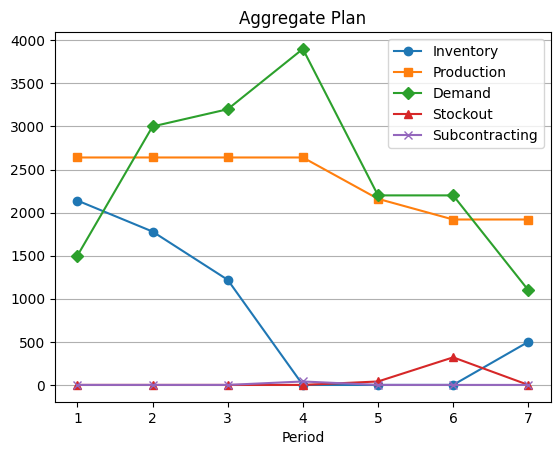

[['December', 0.0, 0.0, 80.0, 0.0, 1000.0, 0.0, 0.0, 0.0, 0.0, nan],
 ['January', 0.0, 14.0, 66.0, 0.0, 2140.0, 0.0, 0.0, 2640.0, 1500.0, 40.0],
 ['February', 0.0, 0.0, 66.0, 0.0, 1780.0, 0.0, 0.0, 2640.0, 3000.0, 40.0],
 ['March', 0.0, 0.0, 66.0, 0.0, 1220.0, 0.0, 0.0, 2640.0, 3200.0, 40.0],
 ['April', 0.0, 0.0, 66.0, 0.0, 0.0, 0.0, 40.0, 2640.0, 3900.0, 40.0],
 ['May', 0.0, 12.0, 54.0, 0.0, 0.0, 40.0, 0.0, 2160.0, 2200.0, 40.0],
 ['June', 0.0, 6.0, 48.0, 0.0, 0.0, 320.0, 0.0, 1920.0, 2200.0, 40.0],
 ['July', 0.0, 0.0, 48.0, 0.0, 500.0, 0.0, 0.0, 1920.0, 1100.0, 40.0]]

In [ ]:
adj_demand = np.array([0, 1500, 3000, 3200, 3800, 2200, 2200])
F = np.array([0, 1600, 3000, 3200, 3800, 2200, 2200, 0])
F[1] = 1500  # Update January demand
F[4] = 3900  # Update April demand
F[7] = 1100  # Add July demand

# Ensure n_months is correctly set to include July if it wasn't already
n_months = max(n_months, 7)

# Create a Gurobi model
model = Model("MinimizeCost")

H = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(0, n_months+1)}
L = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(0, n_months+1)}
W = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(0, n_months+1)}
O = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(0, n_months+1)}
I = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(0, n_months+1)}
S = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(0, n_months+1)}
C = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(0, n_months+1)}
P = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(0, n_months+1)}
D = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(0, n_months+1)}

# Update the model
model.update()

# Set objective function - Total cost = Production & Transportation cost across network + Fixed cost of low cap line + fixed cost of high cap line
model.setObjective(
    quicksum( 300*H[t] + 500*L[t] + 640*W[t] + 6*O[t] + 2*I[t] + 5*S[t] + 30*C[t] + 10*P[t] for t in range(1, n_months+1) ),
    GRB.MINIMIZE)

### Constraints
for t in range(1, n_months+1):

  # Workforce size for each month is based on hiring and layoffs, W_t = W_{t-1} + H_t - L_t
  model.addConstr(W[0] == 80, name=f"Workforce_Beg")
  model.addConstr(W[t] - W[t-1] - H[t] + L[t] == 0, name=f"Workforce_size_constraint_{t}")

  # Demand constraints
  if promote == 0:
      model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
  else:
      if t == month:
          model.addConstr(D[t] == F[t] * (1 + consumption) + forward_buy * (F[t+1] + F[t+2]), name=f"D_constraint_{t}")
      else:
          if t <= 2 + promote:
              if t > promote:
                  model.addConstr(D[t] == (1 - forward_buy) * F[t], name=f"D_constraint_{t}")
              else:
                  model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
          else:
              model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")

  # Inventory balance constraint: I_{t-1} + P_t + C_t = D_t + S_{t-1} + I_t - S_t
  model.addConstr(I[0] == 1000, name=f"Inventory_Beg")
  model.addConstr(I[t-1] + P[t] + C[t] - D[t] - S[t-1] - I[t] + S[t] == 0, name=f"Inventory_constraint_{t}")
  model.addConstr(I[n_months] >= 500, name=f"Inventory_End")

  # Stockout constraint: No stockout at the end
  model.addConstr(S[n_months] == 0, name=f"Stockout_End")

  # Production <= Capacity P_t <= 40 W_t + O_t/4
  model.addConstr(40*W[t] + O[t]/4 - P[t] >= 0, name=f"Capacity_constraint_{t}")

  # Overtime constraint O_t <= 10 W_t
  model.addConstr(10*W[t] - O[t] >= 0, name=f"Overtime_constraint_{t}")


# Suppress optimization output
model.Params.OutputFlag = 0

# Optimize the model
model.optimize()

### Calculate price
Pr = np.zeros(n_months+1)
for t in range(0, n_months + 1):
  if promote == 1 and t == month:
    Pr[t] = promotion_price
  else:
    Pr[t] = base_price
  if t == 0:
    Pr[t] = np.nan

### Total revenue = sumproduct (demand*price)
revenue = sum([D[t].x * Pr[t] for t in range(1, n_months + 1)])

# Store result in table format and print
months = ["December", "January", "February", "March", "April", "May", "June", "July"]

# Store result in table format and print
opt_results_2 = [[months[t]] + [H[t].x] + [L[t].x] + [W[t].x] + [O[t].x] + [I[t].x] + [S[t].x] + [C[t].x] + [P[t].x] + [D[t].x] + [Pr[t]] for t in range(0, n_months + 1)]

headers = ["Period\n(t)"] + ["Hired\n(H)"] + ["Laid Off\n(L)"] + ["Workforce\n(W)"] + ["Overtime\n(O)"] + ["Inventory\n(O)"] + ["Stockout\n(S)"] + ["Subcontract\n(C)"] + ["Production\n(P)"] + ["Demand\n(D)"] + ["Price\n(Pr)"]
print(tabulate(opt_results_2, headers=headers, tablefmt="pretty", stralign="right"))

print(f"Minimum Cost : $ {model.objVal:,.2f}")
print(f"Total Revenue: $ {revenue:,.2f}")
print(f"Profit       : $ {(revenue-model.objVal):,.2f}")

plot_inventory()

opt_results_2


In [ ]:
# Aggregate Plan Costs
head = ["Period\n(t)"] + ["Hired\n(H)"] + ["Laid Off\n(L)"] + ["Regular Time\n(W)"] + ["Overtime\n(O)"] + ["Inventory\n(O)"] + ["Stockout\n(S)"] + ["Subcontract\n(C)"] + ["Material\n(P)"] + ["Total Cost"]

cost_variables = opt_results_2[1:8]

mat_cost = 10 # Cost per unit
inv_cost = 2 # Cost per unit per month
stout_cost = 5 # Cost per unit per month
hire_cost = 300 # Cost per worker
layoff_cost = 500 # Cost per worker
reg_cost = 4 # Cost per hour
over_cost = 6 # Cost per hour
subcon_cost = 30 # Cost per unit


cost_summary = []
for i in range(len(cost_variables)):
  month_cost = [cost_variables[i][0]]
  month_cost.append(cost_variables[i][1]*hire_cost)
  month_cost.append(cost_variables[i][2]*layoff_cost)
  month_cost.append(cost_variables[i][3]*reg_cost*8*20)
  month_cost.append(cost_variables[i][4]*over_cost)
  month_cost.append(cost_variables[i][5]*inv_cost)
  month_cost.append(cost_variables[i][6]*stout_cost)
  month_cost.append(cost_variables[i][7]*subcon_cost)
  month_cost.append(cost_variables[i][8]*mat_cost)
  month_cost.append(sum(month_cost[1:9])) # Chuma this needs to be 9 to be the correct number to incorporate all costs
  cost_summary.append(month_cost)


print(tabulate(cost_summary, headers=head, tablefmt="pretty", stralign="right"))


+----------+-------+----------+--------------+----------+-----------+----------+-------------+----------+------------+
|   Period | Hired | Laid Off | Regular Time | Overtime | Inventory | Stockout | Subcontract | Material | Total Cost |
|      (t) |   (H) |      (L) |          (W) |      (O) |       (O) |      (S) |         (C) |      (P) |            |
+----------+-------+----------+--------------+----------+-----------+----------+-------------+----------+------------+
|  January |   0.0 |   7000.0 |      42240.0 |      0.0 |    4280.0 |      0.0 |         0.0 |  26400.0 |    79920.0 |
| February |   0.0 |      0.0 |      42240.0 |      0.0 |    3560.0 |      0.0 |         0.0 |  26400.0 |    72200.0 |
|    March |   0.0 |      0.0 |      42240.0 |      0.0 |    2440.0 |      0.0 |         0.0 |  26400.0 |    71080.0 |
|    April |   0.0 |      0.0 |      42240.0 |      0.0 |       0.0 |      0.0 |      1200.0 |  26400.0 |    69840.0 |
|      May |   0.0 |   6000.0 |      34560.0 |  

## Question 3 Response:
We can see that the initial model had January costs at 78,480.00. With decrease in demand, the cost actually went up, to 79,920. The costs uncurred went up 1,440

## Q3 Alternative

In [ ]:
# THIS CELL IS MOST LIKELY WRONG - PLEASE REMOVE



# # Updated cost parameter for inventory holding
# holding_cost_per_unit_per_month = 2  # Updated to $2/unit/month based on your table

# unsold_inventory = 100

# # Recalculate additional holding cost with updated parameter
# additional_holding_cost = unsold_inventory * holding_cost_per_unit_per_month

# print(f"Additional holding cost due to reduced demand with updated holding cost: ${additional_holding_cost:.2f}")


SyntaxError: invalid syntax (<ipython-input-54-4025bf06c596>, line 1)

Additionally, in the model from Step 1, the total cost for January was 78,480.00. When only 1500 were sold, our total cost came up to $79920.00.

## Question 4

+----------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
|   Period | Hired | Laid Off | Workforce | Overtime | Inventory | Stockout | Subcontract | Production | Demand | Price |
|      (t) |   (H) |      (L) |       (W) |      (O) |       (O) |      (S) |         (C) |        (P) |    (D) |  (Pr) |
+----------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
|  January |  -0.0 |     -0.0 |      80.0 |     -0.0 |    2060.0 |      0.0 |        -0.0 |       -0.0 |   -0.0 |   nan |
| February |   0.0 |     13.0 |      67.0 |     -0.0 |    1740.0 |     -0.0 |        -0.0 |     2680.0 | 3000.0 |  40.0 |
|    March |   0.0 |     -0.0 |      67.0 |     -0.0 |    1220.0 |     -0.0 |         0.0 |     2680.0 | 3200.0 |  40.0 |
|    April |   0.0 |     -0.0 |      67.0 |     -0.0 |      -0.0 |     -0.0 |         0.0 |     2680.0 | 3900.0 |  40.0 |
|      May |   0.0 |    

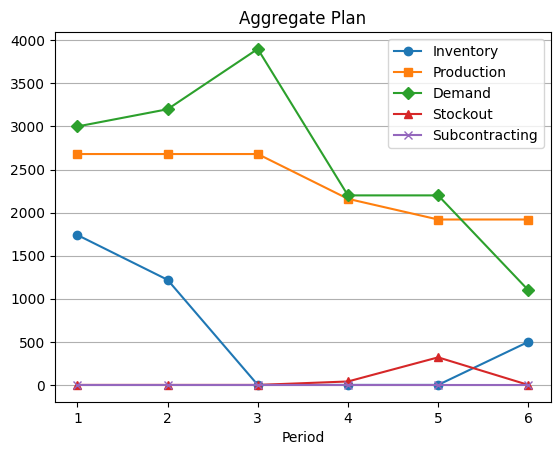

[['January', -0.0, -0.0, 80.0, -0.0, 2060.0, 0.0, -0.0, -0.0, -0.0, nan],
 ['February', 0.0, 13.0, 67.0, -0.0, 1740.0, -0.0, -0.0, 2680.0, 3000.0, 40.0],
 ['March', 0.0, -0.0, 67.0, -0.0, 1220.0, -0.0, 0.0, 2680.0, 3200.0, 40.0],
 ['April', 0.0, -0.0, 67.0, -0.0, -0.0, -0.0, 0.0, 2680.0, 3900.0, 40.0],
 ['May', 0.0, 13.0, 54.0, -0.0, -0.0, 40.0, 0.0, 2160.0, 2200.0, 40.0],
 ['June', 0.0, 6.0, 48.0, -0.0, -0.0, 320.0, 0.0, 1920.0, 2200.0, 40.0],
 ['July', 0.0, -0.0, 48.0, -0.0, 500.0, 0.0, 0.0, 1920.0, 1100.0, 40.0]]

In [ ]:
### User defined variables
promote = 0
month = 4
base_price = 40
promotion_price = base_price - 1
consumption = 0.10
forward_buy = 0.20

F = np.array([0, 3000, 3200, 3900, 2200, 2200, 1100])

### Variables based on input
n_months = len(F)-1
F = np.append(F, [0, 0])


# Create a Gurobi model
model = Model("MinimizeCost")

H = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(0, n_months+1)}
L = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(0, n_months+1)}
W = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(0, n_months+1)}
O = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(0, n_months+1)}
I = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(0, n_months+1)}
S = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(0, n_months+1)}
C = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(0, n_months+1)}
P = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(0, n_months+1)}
D = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(0, n_months+1)}

# Update the model
model.update()

# Set objective function - Total cost = Production & Transportation cost across network + Fixed cost of low cap line + fixed cost of high cap line
model.setObjective(
    quicksum( 300*H[t] + 500*L[t] + 640*W[t] + 6*O[t] + 2*I[t] + 5*S[t] + 30*C[t] + 10*P[t] for t in range(1, n_months+1) ),
    GRB.MINIMIZE)

### Constraints
for t in range(1, n_months+1):

  # Workforce size for each month is based on hiring and layoffs, W_t = W_{t-1} + H_t - L_t
  model.addConstr(W[0] == 80, name=f"Workforce_Beg")
  model.addConstr(W[t] - W[t-1] - H[t] + L[t] == 0, name=f"Workforce_size_constraint_{t}")

  # Demand constraints
  if promote == 0:
      model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
  else:
      if t == month:
          model.addConstr(D[t] == F[t] * (1 + consumption) + forward_buy * (F[t+1] + F[t+2]), name=f"D_constraint_{t}")
      else:
          if t <= 2 + promote:
              if t > promote:
                  model.addConstr(D[t] == (1 - forward_buy) * F[t], name=f"D_constraint_{t}")
              else:
                  model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
          else:
              model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")

  # Inventory balance constraint: I_{t-1} + P_t + C_t = D_t + S_{t-1} + I_t - S_t
  model.addConstr(I[0] == 2060, name=f"Inventory_Beg")
  model.addConstr(I[t-1] + P[t] + C[t] - D[t] - S[t-1] - I[t] + S[t] == 0, name=f"Inventory_constraint_{t}")
  model.addConstr(I[n_months] >= 500, name=f"Inventory_End")

  # Stockout constraint: No stockout at the end
  model.addConstr(S[n_months] == 0, name=f"Stockout_End")

  # Production <= Capacity P_t <= 40 W_t + O_t/4
  model.addConstr(40*W[t] + O[t]/4 - P[t] >= 0, name=f"Capacity_constraint_{t}")

  # Overtime constraint O_t <= 10 W_t
  model.addConstr(10*W[t] - O[t] >= 0, name=f"Overtime_constraint_{t}")


# Suppress optimization output
model.Params.OutputFlag = 0

# Optimize the model
model.optimize()

### Calculate price
Pr = np.zeros(n_months+1)
for t in range(0, n_months + 1):
  if promote == 1 and t == month:
    Pr[t] = promotion_price
  else:
    Pr[t] = base_price
  if t == 0:
    Pr[t] = np.nan

### Total revenue = sumproduct (demand*price)
revenue = sum([D[t].x * Pr[t] for t in range(1, n_months + 1)])

# Store result in table format and print
months = [ "January", "February", "March", "April", "May", "June", "July"]

# Store result in table format and print
opt_results_2 = [[months[t]] + [H[t].x] + [L[t].x] + [W[t].x] + [O[t].x] + [I[t].x] + [S[t].x] + [C[t].x] + [P[t].x] + [D[t].x] + [Pr[t]] for t in range(0, n_months + 1)]

headers = ["Period\n(t)"] + ["Hired\n(H)"] + ["Laid Off\n(L)"] + ["Workforce\n(W)"] + ["Overtime\n(O)"] + ["Inventory\n(O)"] + ["Stockout\n(S)"] + ["Subcontract\n(C)"] + ["Production\n(P)"] + ["Demand\n(D)"] + ["Price\n(Pr)"]
print(tabulate(opt_results_2, headers=headers, tablefmt="pretty", stralign="right"))

print(f"Minimum Cost : $ {model.objVal:,.2f}")
print(f"Total Revenue: $ {revenue:,.2f}")
print(f"Profit       : $ {(revenue-model.objVal):,.2f}")

plot_inventory()

opt_results_2


In [ ]:
# Aggregate Plan Costs
head = ["Period\n(t)"] + ["Hired\n(H)"] + ["Laid Off\n(L)"] + ["Regular Time\n(W)"] + ["Overtime\n(O)"] + ["Inventory\n(O)"] + ["Stockout\n(S)"] + ["Subcontract\n(C)"] + ["Material\n(P)"] + ["Total Cost"]

cost_variables = opt_results_2[1:8]

mat_cost = 10 # Cost per unit
inv_cost = 2 # Cost per unit per month
stout_cost = 5 # Cost per unit per month
hire_cost = 300 # Cost per worker
layoff_cost = 500 # Cost per worker
reg_cost = 4 # Cost per hour
over_cost = 6 # Cost per hour
subcon_cost = 30 # Cost per unit


cost_summary = []
for i in range(len(cost_variables)):
  month_cost = [cost_variables[i][0]]
  month_cost.append(cost_variables[i][1]*hire_cost)
  month_cost.append(cost_variables[i][2]*layoff_cost)
  month_cost.append(cost_variables[i][3]*reg_cost*8*20)
  month_cost.append(cost_variables[i][4]*over_cost)
  month_cost.append(cost_variables[i][5]*inv_cost)
  month_cost.append(cost_variables[i][6]*stout_cost)
  month_cost.append(cost_variables[i][7]*subcon_cost)
  month_cost.append(cost_variables[i][8]*mat_cost)
  month_cost.append(sum(month_cost[1:9])) # Chuma this needs to be 9 to be the correct number to incorporate all costs
  cost_summary.append(month_cost)


print(tabulate(cost_summary, headers=head, tablefmt="pretty", stralign="right"))

+----------+-------+----------+--------------+----------+-----------+----------+-------------+----------+------------+
|   Period | Hired | Laid Off | Regular Time | Overtime | Inventory | Stockout | Subcontract | Material | Total Cost |
|      (t) |   (H) |      (L) |          (W) |      (O) |       (O) |      (S) |         (C) |      (P) |            |
+----------+-------+----------+--------------+----------+-----------+----------+-------------+----------+------------+
| February |   0.0 |   6500.0 |      42880.0 |     -0.0 |    3480.0 |     -0.0 |        -0.0 |  26800.0 |    79660.0 |
|    March |   0.0 |     -0.0 |      42880.0 |     -0.0 |    2440.0 |     -0.0 |         0.0 |  26800.0 |    72120.0 |
|    April |   0.0 |     -0.0 |      42880.0 |     -0.0 |      -0.0 |     -0.0 |         0.0 |  26800.0 |    69680.0 |
|      May |   0.0 |   6500.0 |      34560.0 |     -0.0 |      -0.0 |    200.0 |         0.0 |  21600.0 |    62860.0 |
|     June |   0.0 |   3000.0 |      30720.0 |  

### Cost differences

\begin{array}{|l|r|r|r|}
\hline
\textbf{Period} & \textbf{Total Cost (Original)} & \textbf{Total Cost (Last Model)} & \textbf{Difference in Cost (New model - original)} \\
\hline
\text{January} & 78480.0 & 79920.0 & 1440.0 \\
\text{February} & 69600.0 & 79660.0 & 10060.0 \\
\text{March} & 68320.0 & 72120.0 & 3800.0 \\
\text{April} & 71860.0 & 69680.0 & -2180.0 \\
\text{May} & 66840.0 & 62860.0 & -3980.0 \\
\text{June} & 67560.0 & 54520.0 & -13040.0 \\
\text{July} & N/A & 50920.0 & N/A \\
\hline
\end{array}


# Questions
* Q1) 3 - Is the incurred cost now just holding cost into quantity unsold?
* Q2) 4 - Is the new plan just re-running the model with new demand and constraint of january inventory =100? Am I just pushing step 1 ahead by one month Can I just calculated the cost as I did in question 1?